# Long Term CO2 Flux Trends: Anthropogenic or Natural?

Inspired by this comment by Gruber:

---

**Nicolas Gruber:** How did you make this attribution? It is quite certainly correct, but you should state the basis for this argument. I my suspicion is right, then you used the long-term trend of the ensemble mean to establish the contribution of anthropogenic CO2. This is only approximately correct, since this trend includes also climate-change driven trends in the fluxes of natural and anthropogenic CO2. Please explain.

---

Basically, the question is, what drives the ensemble mean trend? Is there a natural trend involved?

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

import esmtools as et

# Stats
from scipy import stats
from scipy.special import ndtri, ndtr
import sys
import numpy.polynomial.polynomial as poly

## Functions and Data

In [2]:
# MANN-KENDALL TEST
def test(t, x, eps=None, alpha=None, Ha=None):
    """
    Runs the Mann-Kendall test for trend in time series data.
    Parameters
    ----------
    t : 1D numpy.ndarray
        array of the time points of measurements
    x : 1D numpy.ndarray
        array containing the measurements corresponding to entries of 't'
    eps : scalar, float, greater than zero
        least count error of measurements which help determine ties in the data
    alpha : scalar, float, greater than zero
        significance level of the statistical test (Type I error)
    Ha : string, options include 'up', 'down', 'upordown'
        type of test: one-sided ('up' or 'down') or two-sided ('updown')
    Returns
    -------
    MK : string
        result of the statistical test indicating whether or not to accept hte
        alternative hypothesis 'Ha'
    m : scalar, float
        slope of the linear fit to the data
    c : scalar, float
        intercept of the linear fit to the data
    p : scalar, float, greater than zero
        p-value of the obtained Z-score statistic for the Mann-Kendall test
    Raises
    ------
    AssertionError : error
                    least count error of measurements 'eps' is not given
    AssertionError : error
                    significance level of test 'alpha' is not given
    AssertionError : error
                    alternative hypothesis 'Ha' is not given
    """
    # assert a least count for the measurements x
    assert eps, "Please provide least count error for measurements 'x'"
    assert alpha, "Please provide significance level 'alpha' for the test"
    assert Ha, "Please provide the alternative hypothesis 'Ha'"

    # estimate sign of all possible (n(n-1)) / 2 differences
    n = len(t)
    sgn = np.zeros((n, n), dtype="int")
    for i in range(n):
        tmp = x - x[i]
        tmp[np.where(np.fabs(tmp) <= eps)] = 0.
        sgn[i] = np.sign(tmp)

    # estimate mean of the sign of all possible differences
    S = sgn[np.triu_indices(n, k=1)].sum()

    # estimate variance of the sign of all possible differences
    # 1. Determine no. of tie groups 'p' and no. of ties in each group 'q'
    np.fill_diagonal(sgn, eps * 1E6)
    i, j = np.where(sgn == 0.)
    ties = np.unique(x[i])
    p = len(ties)
    q = np.zeros(len(ties), dtype="int")
    for k in range(p):
        idx =  np.where(np.fabs(x - ties[k]) < eps)[0]
        q[k] = len(idx)
    # 2. Determine the two terms in the variance calculation
    term1 = n * (n - 1) * (2 * n + 5)
    term2 = (q * (q - 1) * (2 * q + 5)).sum()
    # 3. estimate variance
    varS = float(term1 - term2) / 18.

    # Compute the Z-score based on above estimated mean and variance
    if S > eps:
        Zmk = (S - 1) / np.sqrt(varS)
    elif np.fabs(S) <= eps:
        Zmk = 0.
    elif S < -eps:
        Zmk = (S + 1) / np.sqrt(varS)

    # compute test based on given 'alpha' and alternative hypothesis
    # note: for all the following cases, the null hypothesis Ho is:
    # Ho := there is no monotonic trend
    # 
    # Ha := There is an upward monotonic trend
    if Ha == "up":
        Z_ = ndtri(1. - alpha)
        if Zmk >= Z_:
            MK = "accept Ha := upward trend"
        else:
            MK = "reject Ha := upward trend"
    # Ha := There is a downward monotonic trend
    elif Ha == "down":
        Z_ = ndtri(1. - alpha)
        if Zmk <= -Z_:
            MK = "accept Ha := downward trend"
        else:
            MK = "reject Ha := downward trend"
    # Ha := There is an upward OR downward monotonic trend
    elif Ha == "upordown":
        Z_ = ndtri(1. - alpha / 2.)
        if np.fabs(Zmk) >= Z_:
            MK = "accept Ha := upward OR downward trend"
        else:
            MK = "reject Ha := upward OR downward trend"

    # ----------
    # AS A BONUS
    # ----------
    # estimate the slope and intercept of the line
    m = np.corrcoef(t, x)[0, 1] * (np.std(x) / np.std(t))
    c = np.mean(x) - m * np.mean(t)

    # ----------
    # AS A BONUS
    # ----------
    # estimate the p-value for the obtained Z-score Zmk
    if S > eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (1. - ndtr(Zmk))
    elif np.fabs(S) <= eps:
        p = 0.5
    elif S < -eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (ndtr(Zmk))
    return MK, m, c, p

In [3]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    fileDir = '/glade/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

In [86]:
EBU = 'BenCS'

ant_mean, _, _ = load_in_filtered_data('FG_ANT_CO2', EBU)
con_mean, _, _ = load_in_filtered_data('FG_CO2', EBU)
nat_mean, _, _ = load_in_filtered_data('FG_ALT_CO2', EBU)

## Compute trend for each

In [87]:
def compute_slope(da):
    """
    Compute the linear trend of the ensemble mean. And check significance.
    """
    t = da['time'].values
    x = np.arange(0, len(t), 1)
    slope, *_ = stats.linregress(x, da)
    
    MK, m, c, p = test(x, da.values, eps=1E-3, alpha=0.05, Ha='down')
    return (slope * len(t)), MK

In [88]:
slope_c, MK_c = compute_slope(con_mean['FG_CO2_AW'])
slope_a, MK_a = compute_slope(ant_mean['FG_ANT_CO2_AW'])
slope_n, MK_n = compute_slope(nat_mean['FG_ALT_CO2_AW'])

In [89]:
print("Contemporary Slope: " + str(slope_c.round(3)))
print("Anthropogenic Slope: " + str(slope_a.round(3)))
print("Natural Slope: " + str(slope_n.round(3)))

Contemporary Slope: -0.759
Anthropogenic Slope: -0.823
Natural Slope: 0.065


In [90]:
print("Contemporary Sig: " + MK_c)
print("Anthropogenic Sig: " + MK_c)
print("Natural Sig: " + MK_c)

Contemporary Sig: accept Ha := downward trend
Anthropogenic Sig: accept Ha := downward trend
Natural Sig: accept Ha := downward trend


(-2, 5)

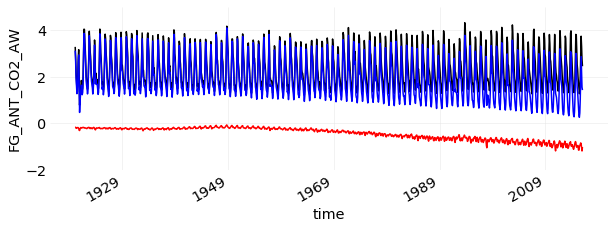

In [91]:
f, ax = plt.subplots(figsize=(10,3))
nat_mean['FG_ALT_CO2_AW'].plot(color='k', linewidth=1.5)
con_mean['FG_CO2_AW'].plot(color='b', linewidth=1.5)
ant_mean['FG_ANT_CO2_AW'].plot(color='r', linewidth=1.5)
ax.set_ylim([-2, 5])